In [1]:
##IMPORTING THE REQUIRED LIBRARIERS

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error ,mean_squared_error, r2_score
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor

In [2]:
###LOADING THE DATASETS
df = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
var = pd.read_csv('VariableDescriptions.csv')

####LET US DROP THE COLUMN ID
df.drop(columns =['ID'], inplace =True)
test.drop(columns = ['ID'], inplace =True)

In [3]:
## let us rename the columns in train set 
rename = {'distance-to-solar-noon':'distance_to_solar_noon',
          'wind-direction':'wind_direction',
          'wind-speed': 'wind_speed',
           'sky-cover': 'sky_cover',
          'average-wind-speed-(period)':'avg_wind_speed_pd',
          'average-pressure-(period)':'avg_pressure_pd',
          'power-generated': 'power_generated'
          }
df.rename(columns=rename, inplace=True)


## let us rename the columns test set
Rename = {'distance-to-solar-noon':'distance_to_solar_noon',
          'wind-direction':'wind_direction',
          'wind-speed': 'wind_speed',
           'sky-cover': 'sky_cover',
          'average-wind-speed-(period)':'avg_wind_speed_pd',
          'average-pressure-(period)':'avg_pressure_pd'
    
          }
test.rename(columns=Rename, inplace=True)

In [4]:
df.shape, test.shape
print(f"training set contains {df.shape[0]} rows and {df.shape[1]} columns")
print(f"test set contains {test.shape[0]} rows and {test.shape[1]} columns")
## our target column is power_generated 
### our target is continuous variable hence we have a regression problem to solve.

training set contains 2043 rows and 10 columns
test set contains 877 rows and 9 columns


In [5]:
df

,distance_to_solar_noon,temperature,wind_direction,wind_speed,sky_cover,visibility,humidity,avg_wind_speed_pd,avg_pressure_pd,power_generated
0,0.168350,52,6,1.1,0,6.0,80,8.0,766.572,22482
1,0.349153,63,26,16.3,4,10.0,81,16.0,760.984,1755
2,0.857875,63,27,13.9,4,10.0,93,11.0,758.444,0
3,0.150113,70,30,9.7,0,9.0,71,3.0,759.968,27771
4,0.465986,63,27,16.0,1,10.0,72,16.0,759.460,1748
...,...,...,...,...,...,...,...,...,...,...
2038,0.750436,51,14,10.4,4,8.0,83,6.0,757.936,0
2039,0.079670,66,29,7.3,1,10.0,34,16.0,761.746,27284
2040,0.256208,63,29,9.8,1,10.0,57,16.0,758.698,21718
2041,0.441617,70,31,4.4,2,10.0,81,0.0,763.270,2718


In [6]:
###Data Preprocessing and summary in training set
data_df= pd.DataFrame()

def summary (data):
    data['null_value'] = df.isna().sum()
    data['unique_value'] = df.nunique()
    data['data_type'] = df.dtypes
    data['duplicate_value'] = df.duplicated().sum()
    data['min_value'] = df.min()
    data['max'] = df.max()
    return data
data_df = summary(data_df)
data_df

,null_value,unique_value,data_type,duplicate_value,min_value,max
distance_to_solar_noon,0,1915,float64,0,0.050401,1.141361
temperature,0,37,int64,0,42.000000,78.000000
wind_direction,0,35,int64,0,1.000000,36.000000
wind_speed,0,159,float64,0,1.100000,26.600000
sky_cover,0,5,int64,0,0.000000,4.000000
visibility,0,16,float64,0,0.250000,10.000000
humidity,0,74,int64,0,14.000000,100.000000
avg_wind_speed_pd,0,29,float64,0,0.000000,36.000000
avg_pressure_pd,0,88,float64,0,748.792000,775.462000
power_generated,0,1082,int64,0,0.000000,36368.000000


In [7]:
##from the above sumary, we can see that the training set does not contain null values and no duplicates.
##Also all our columms are numerical in nature.

In [8]:
###Data Preprocessing and summary in test set
data_test= pd.DataFrame()

def summary (data):
    data['null_value'] = test.isna().sum()
    data['unique_value'] = test.nunique()
    data['data_type'] = test.dtypes
    data['duplicate_value'] = test.duplicated().sum()
    data['min_value'] = test.min()
    data['max'] = test.max()
    return data
data_test = summary(data_test)
data_test

,null_value,unique_value,data_type,duplicate_value,min_value,max
distance_to_solar_noon,0,841,float64,0,0.050575,1.141115
temperature,0,37,int64,0,42.000000,78.000000
wind_direction,0,35,int64,0,1.000000,36.000000
wind_speed,0,156,float64,0,1.100000,26.600000
sky_cover,0,5,int64,0,0.000000,4.000000
visibility,0,12,float64,0,0.000000,10.000000
humidity,0,69,int64,0,21.000000,100.000000
avg_wind_speed_pd,1,31,float64,0,0.000000,40.000000
avg_pressure_pd,0,75,float64,0,749.808000,775.208000


In [9]:
### Average wind speed contains only one missing value and test set all does no have duplicates
## All the columns are also numerical.

###Lel us handle the null value spoted in the test set by fill with the mean value in the specific column.
test['avg_wind_speed_pd'] = test['avg_wind_speed_pd'].fillna(test['avg_wind_speed_pd'].mean())

In [10]:
##NO MORE MISSING VALUE IN TEST SET
test.isna().sum()

distance_to_solar_noon    0
temperature               0
wind_direction            0
wind_speed                0
sky_cover                 0
visibility                0
humidity                  0
avg_wind_speed_pd         0
avg_pressure_pd           0
dtype: int64

In [11]:
###STATICAL ANALYSIS OF TRAIN SET 
df.describe()

,distance_to_solar_noon,temperature,wind_direction,wind_speed,sky_cover,visibility,humidity,avg_wind_speed_pd,avg_pressure_pd,power_generated
count,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000
mean,0.502832,58.436123,24.974058,10.167890,2.031816,9.533284,73.829173,10.186001,762.415501,7013.814978
std,0.300881,6.892146,6.907519,4.720182,1.408477,1.432276,14.898668,7.215085,3.605443,10367.073241
min,0.050401,42.000000,1.000000,1.100000,0.000000,0.250000,14.000000,0.000000,748.792000,0.000000
25%,0.205883,53.000000,26.000000,6.600000,1.000000,10.000000,65.000000,5.000000,759.968000,0.000000
50%,0.480836,59.000000,27.000000,10.100000,2.000000,10.000000,77.000000,9.000000,761.746000,404.000000
75%,0.743571,63.000000,29.000000,13.100000,3.000000,10.000000,84.000000,15.000000,764.794000,12800.500000
max,1.141361,78.000000,36.000000,26.600000,4.000000,10.000000,100.000000,36.000000,775.462000,36368.000000


# DATA VISUALISATION 

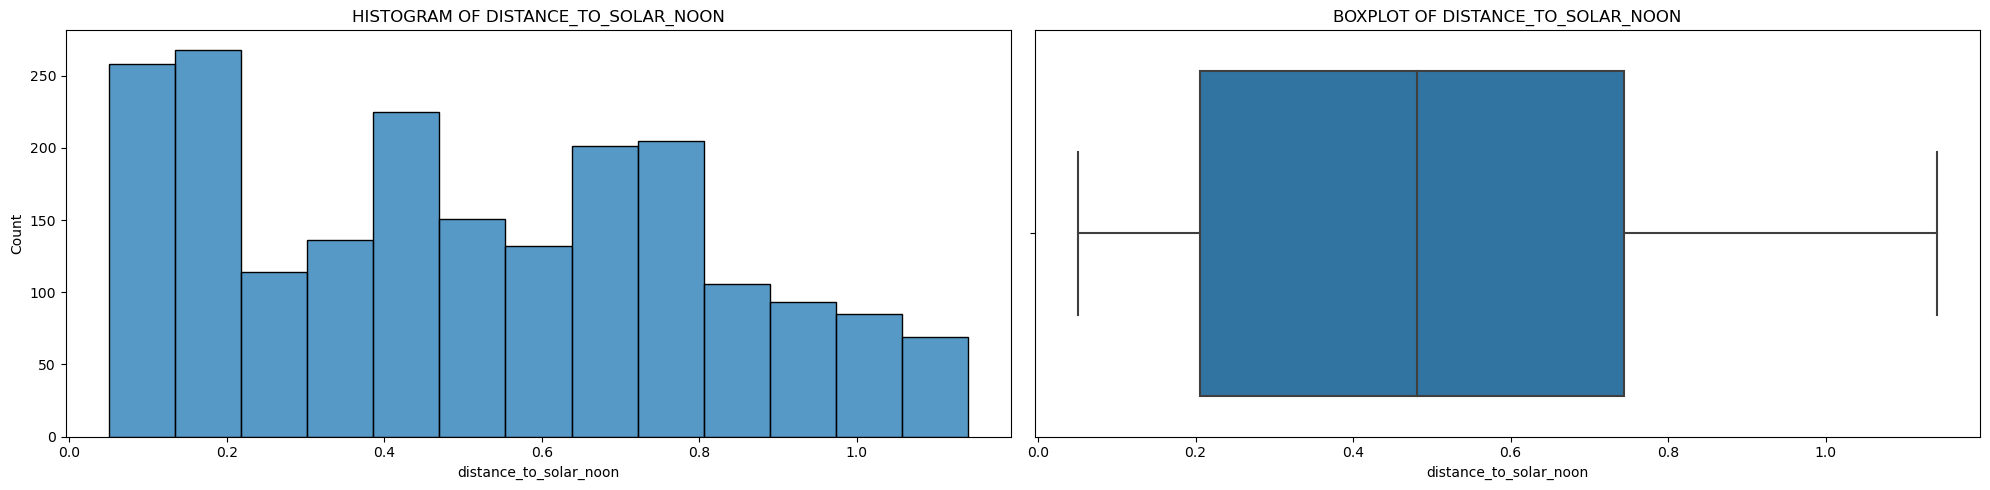

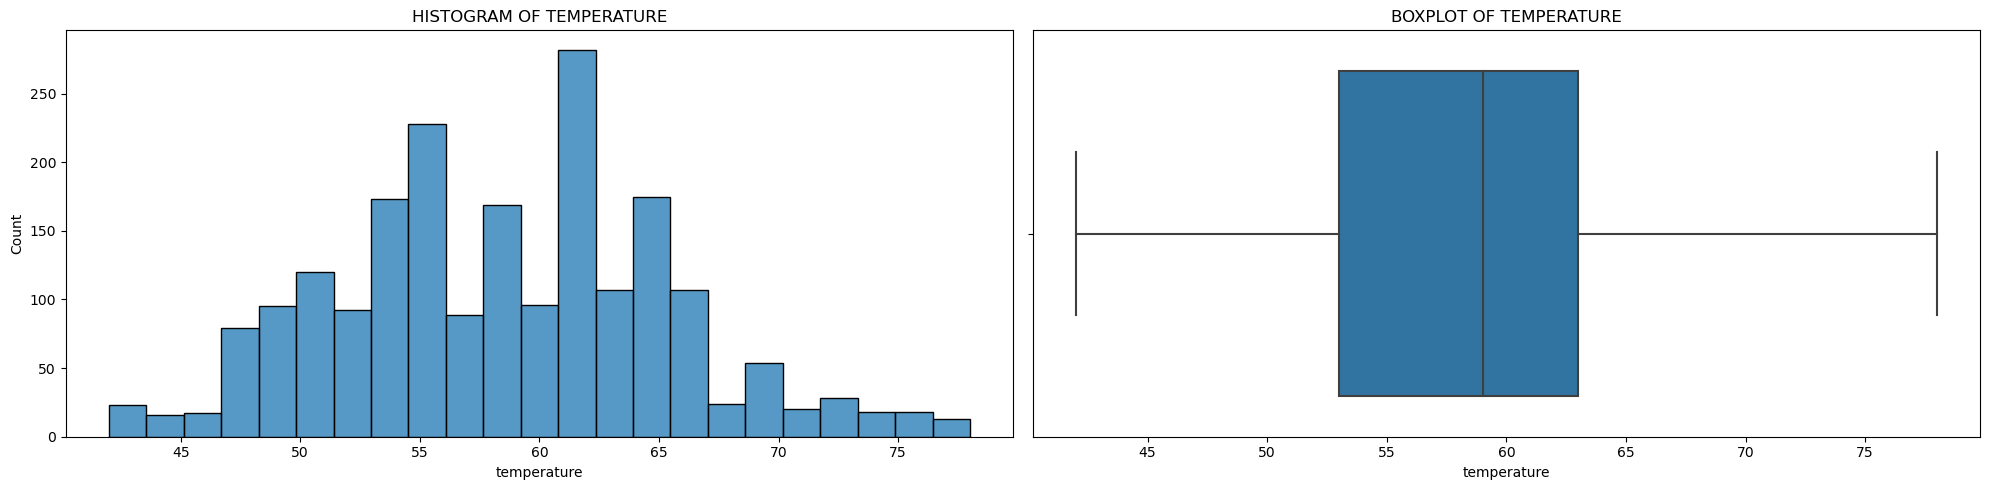

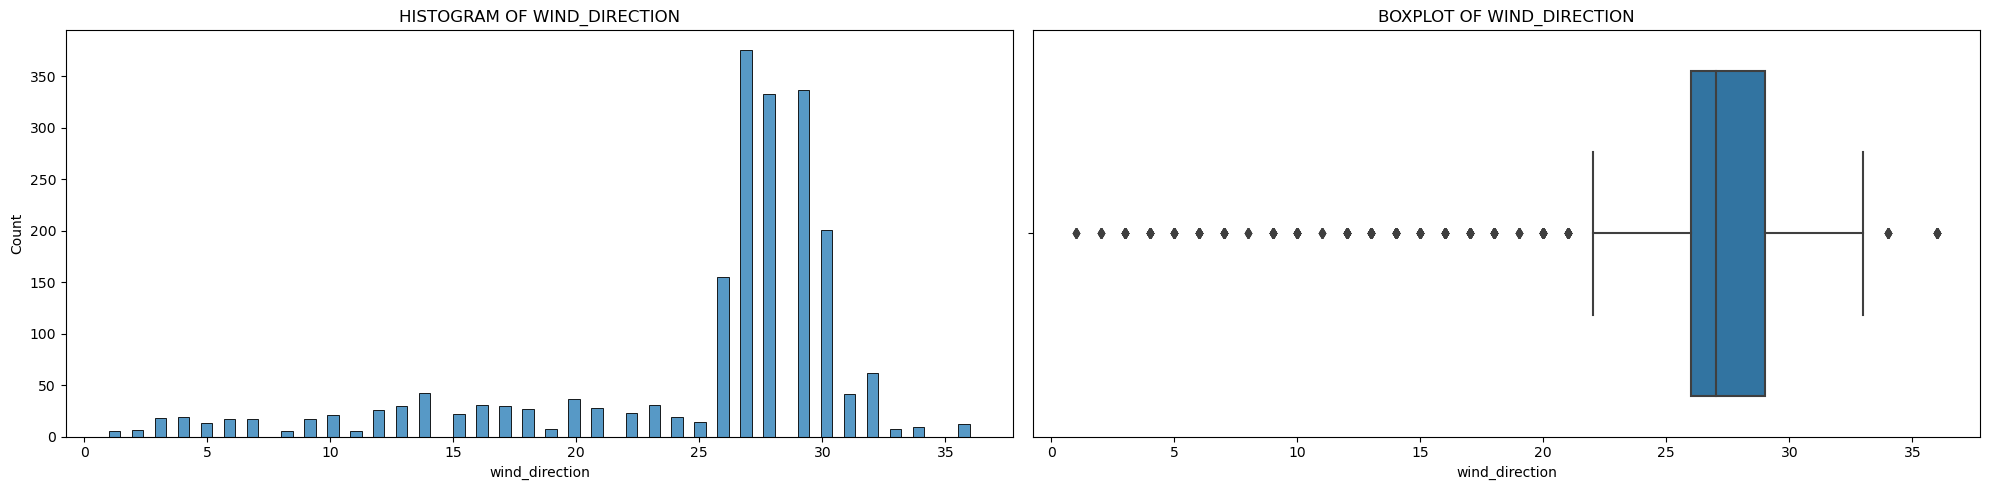

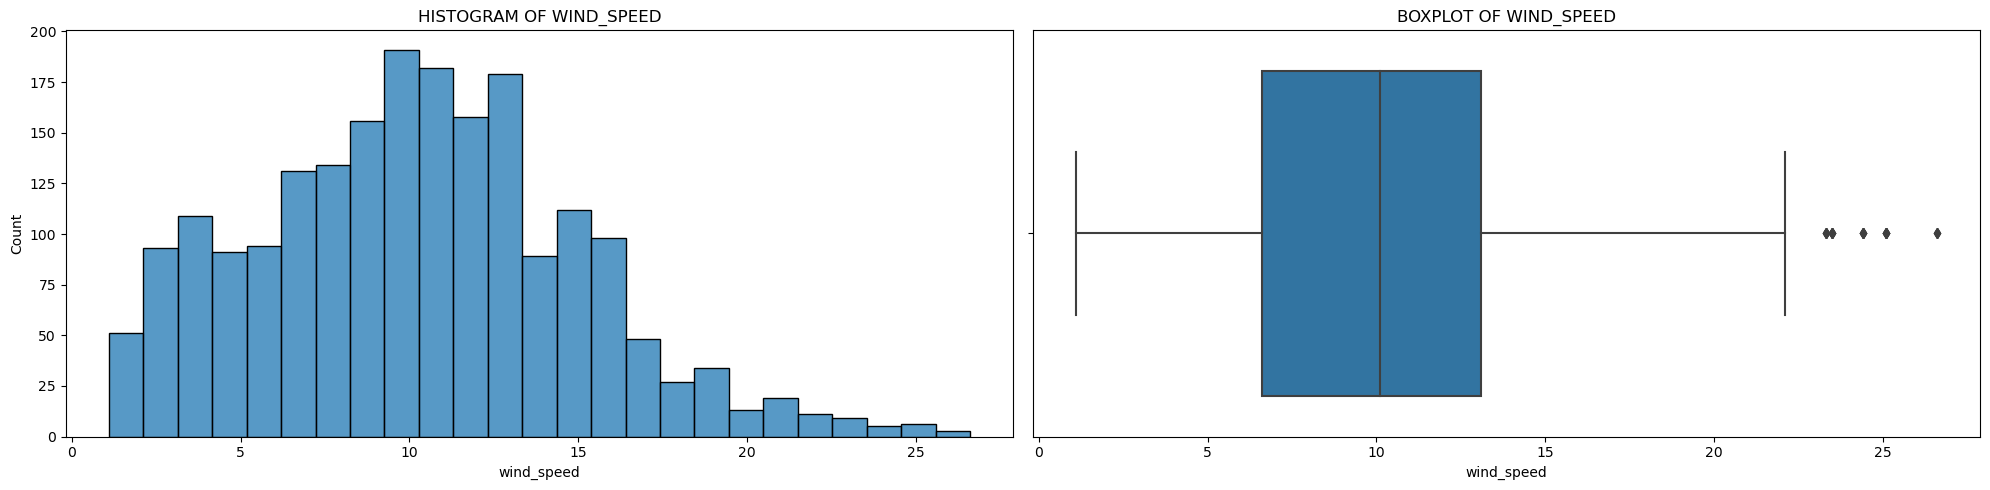

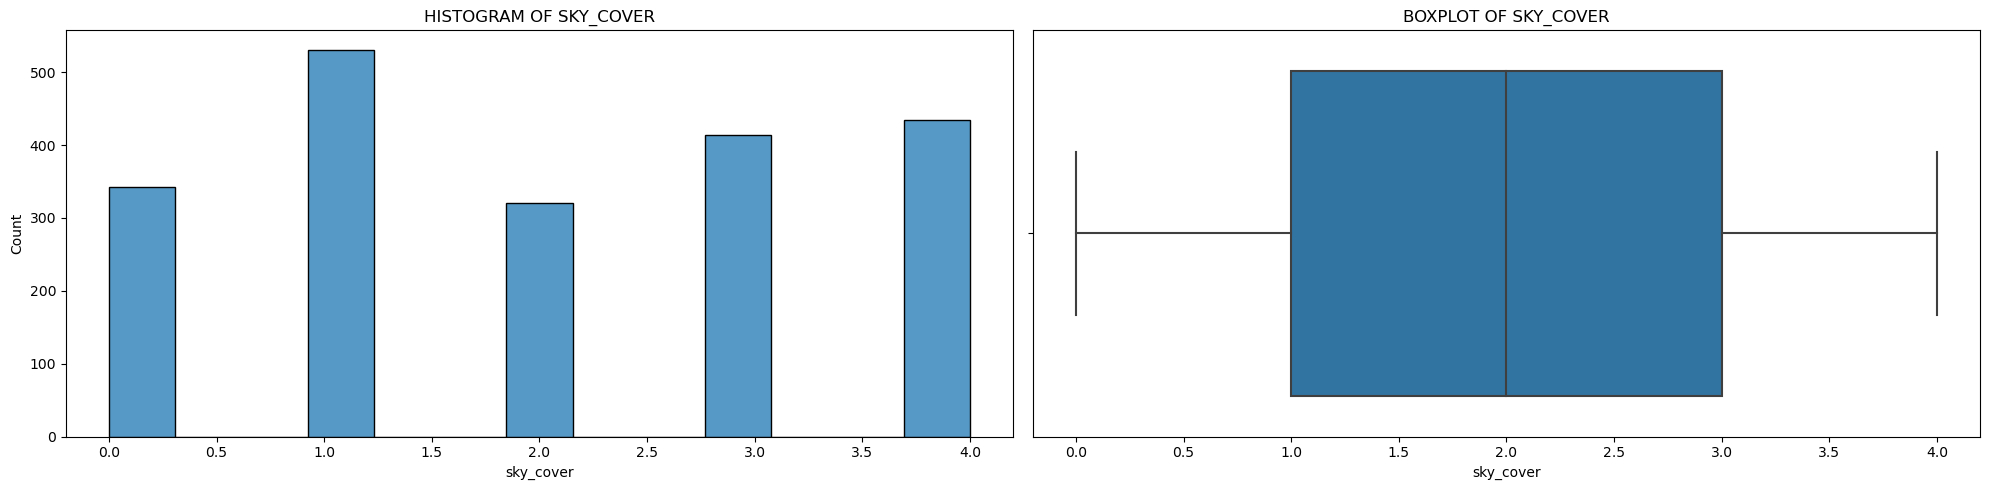

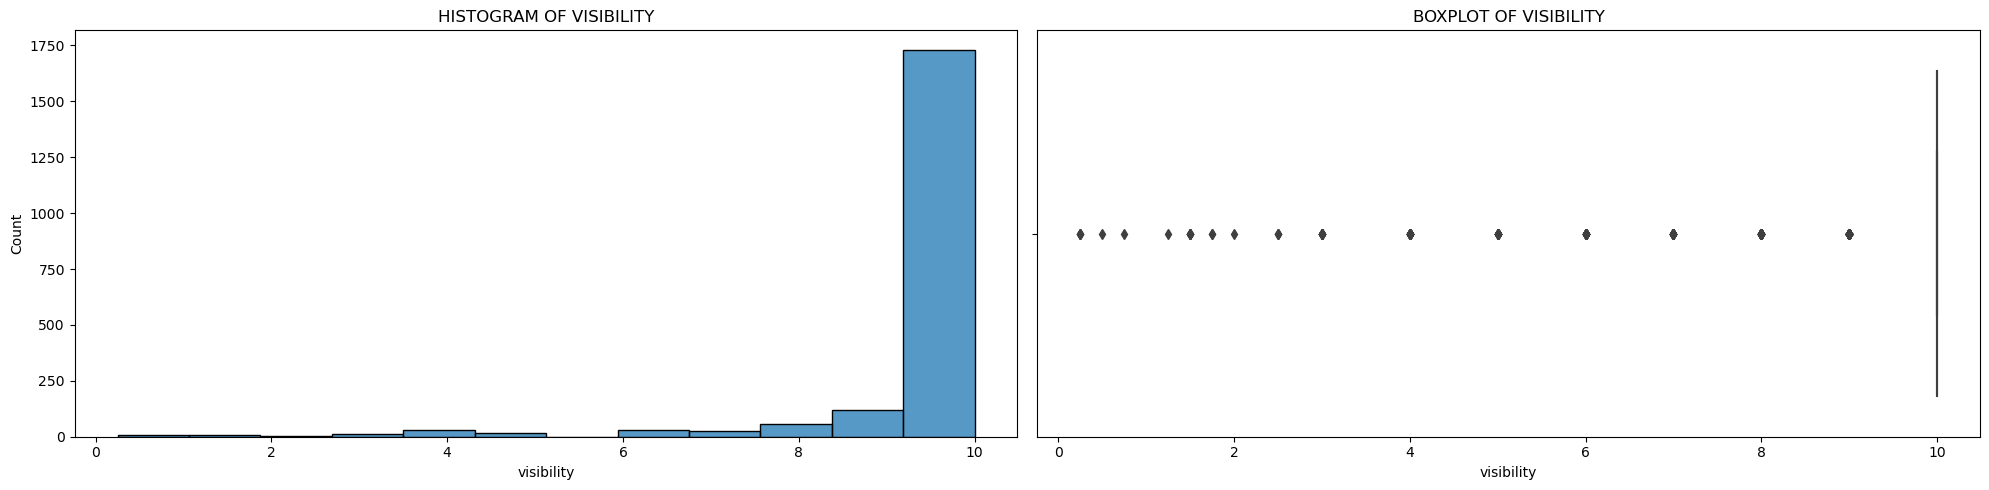

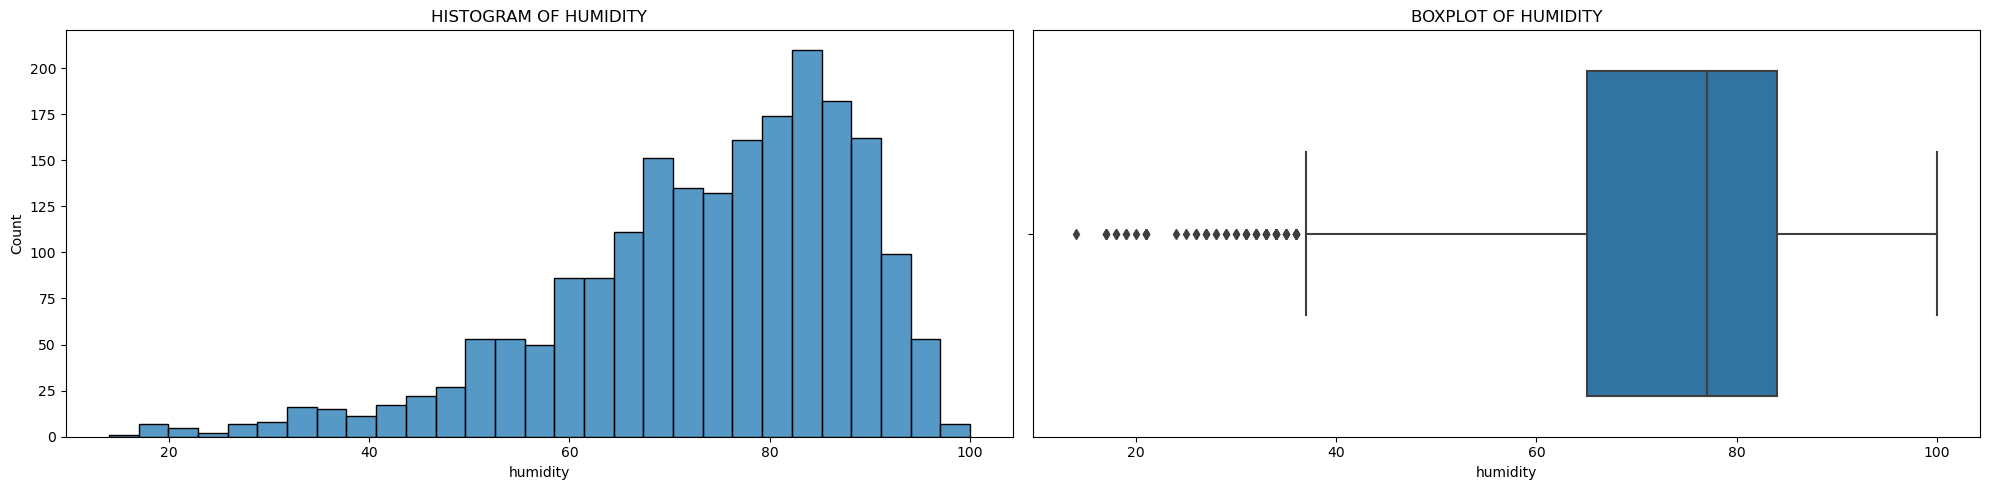

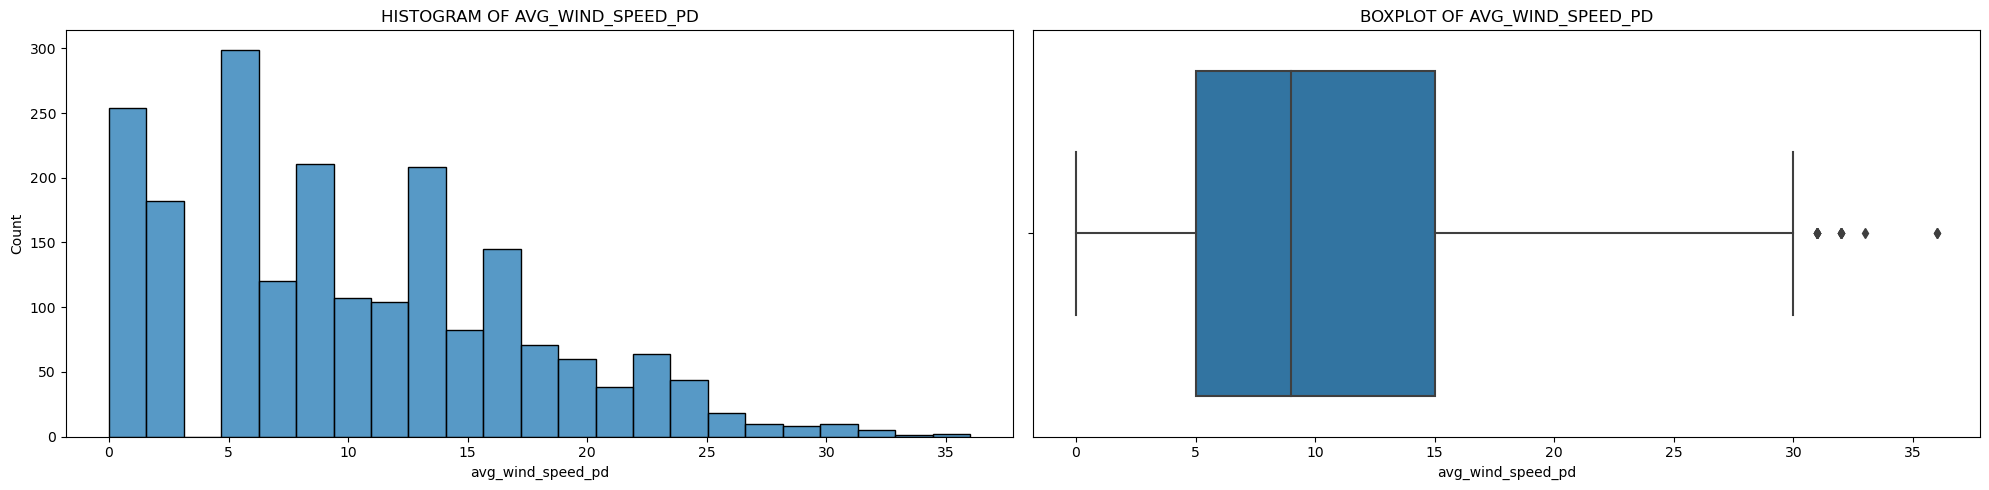

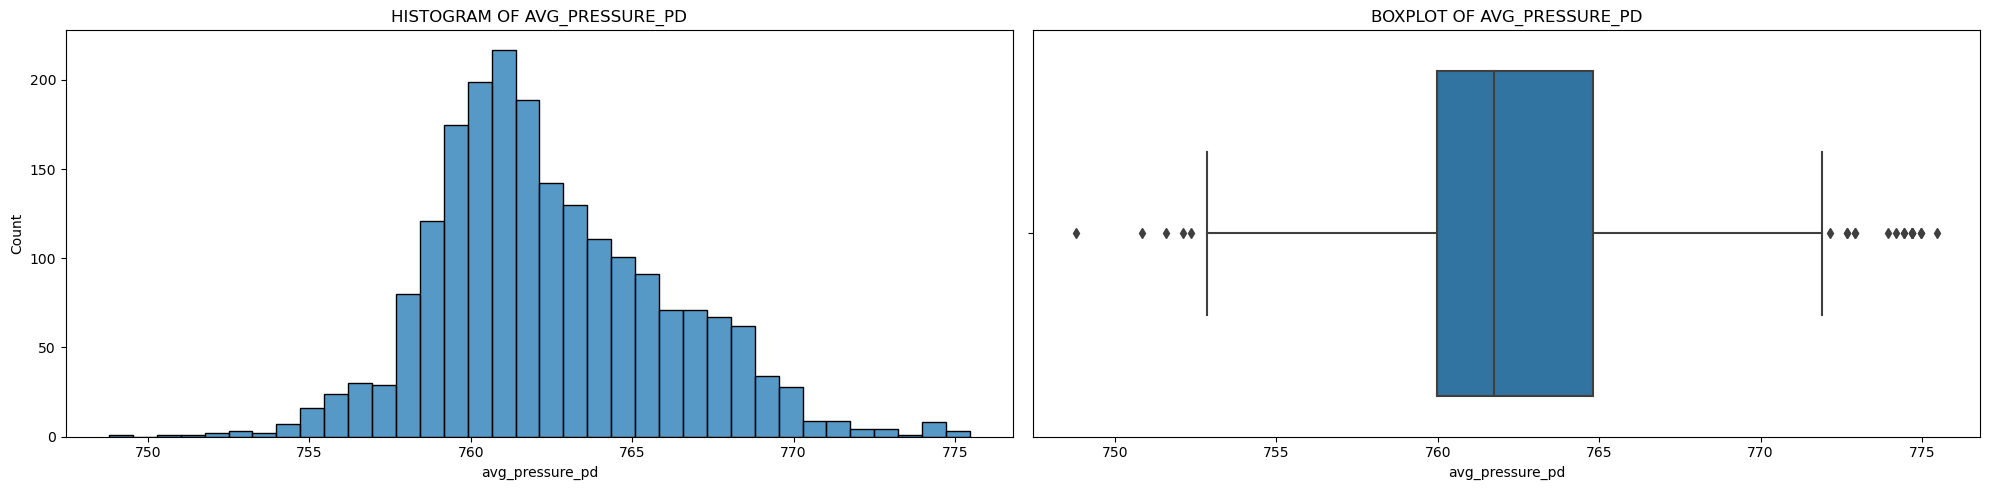

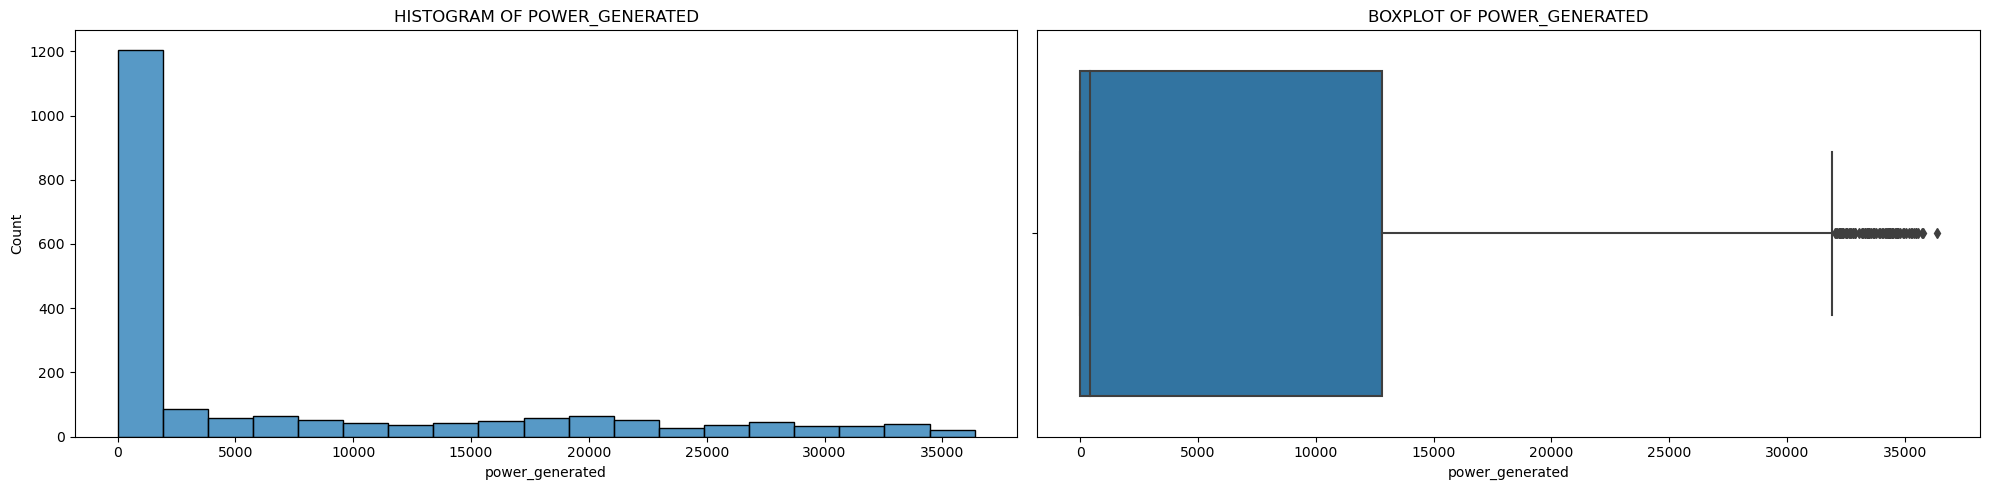

In [12]:
for num in df.columns:
    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    plt.title(f'histogram of {num}'.upper())
    sns.histplot(x =df[num]),
    
    plt.subplot(1,2,2)
    plt.title(f"BOXPLOT OF {num}". upper())
    sns.boxplot(x =df[num])
    plt.tight_layout()
    plt.show()

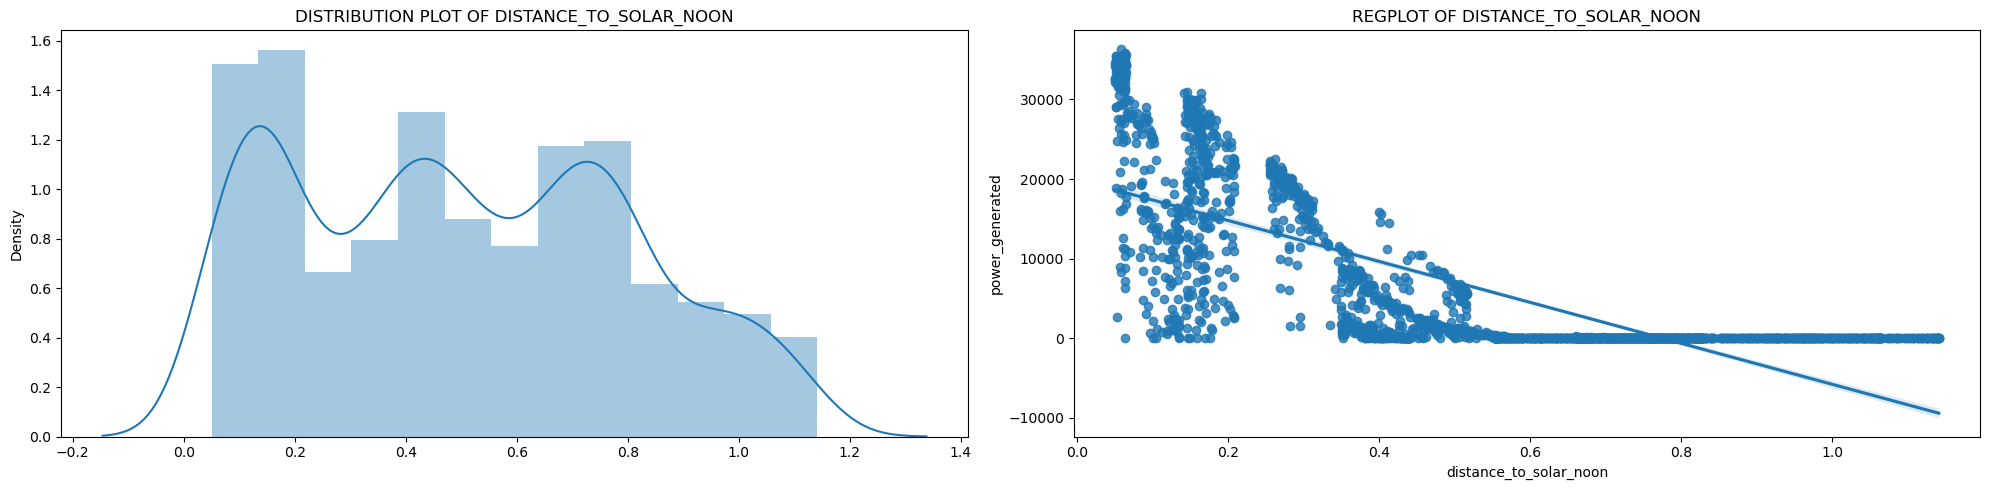

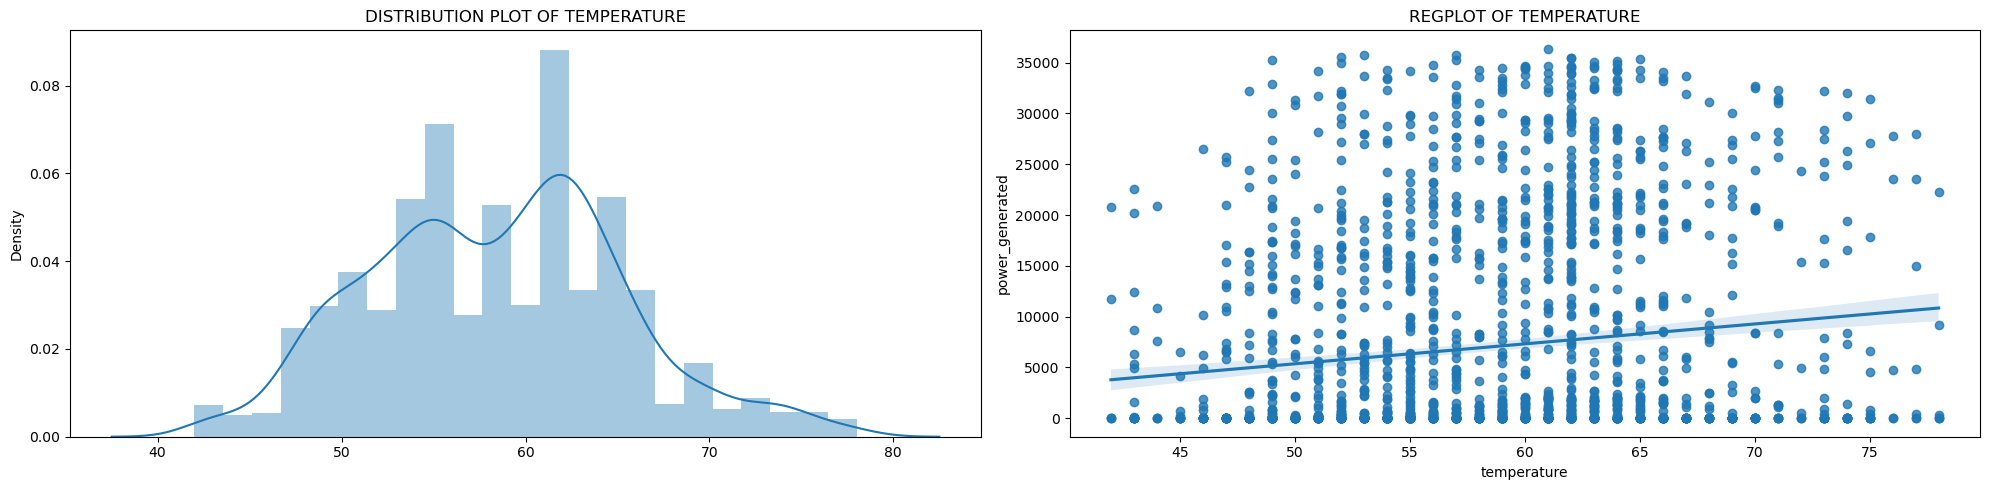

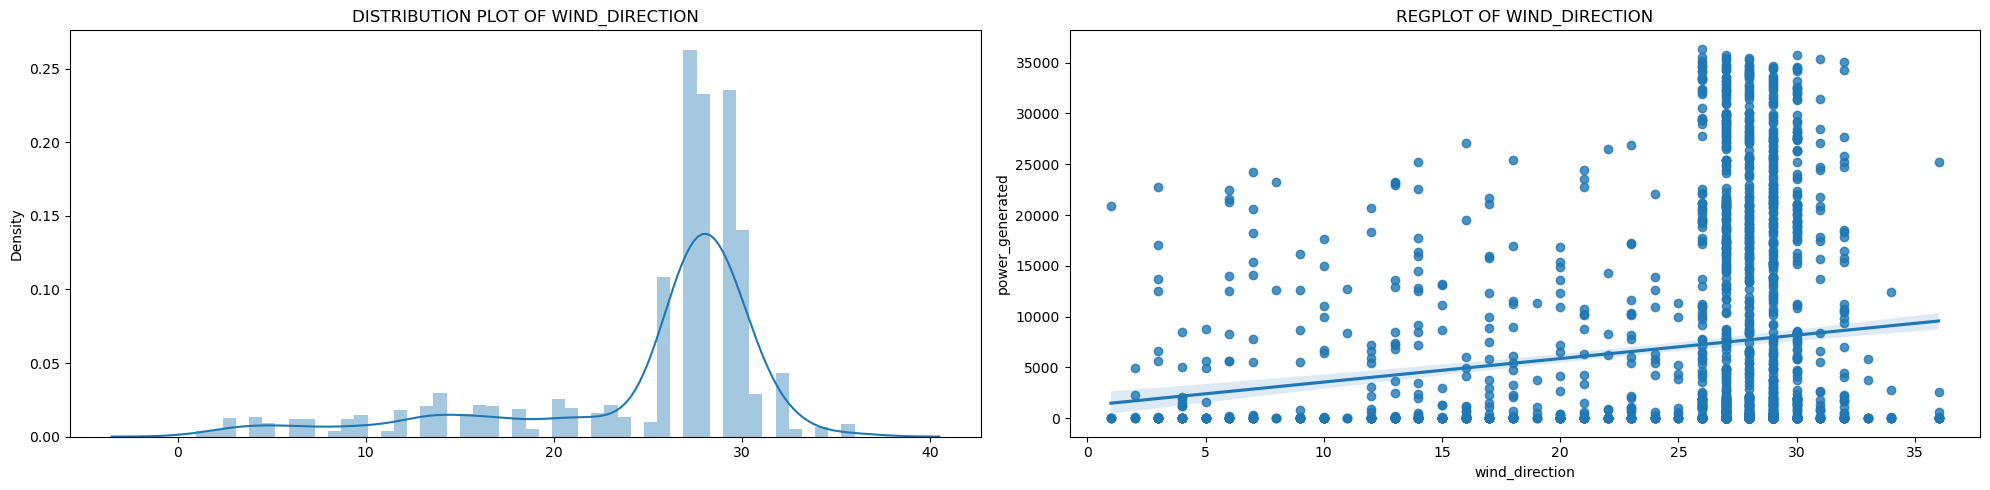

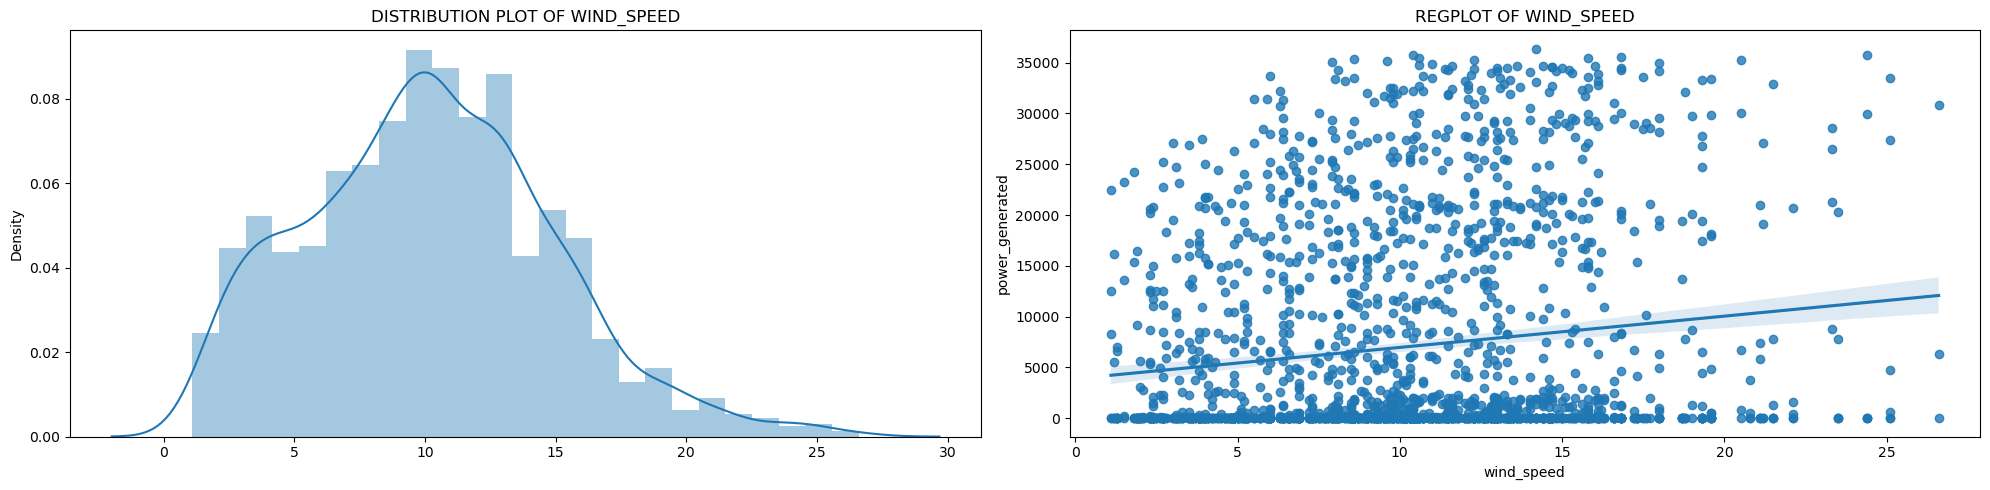

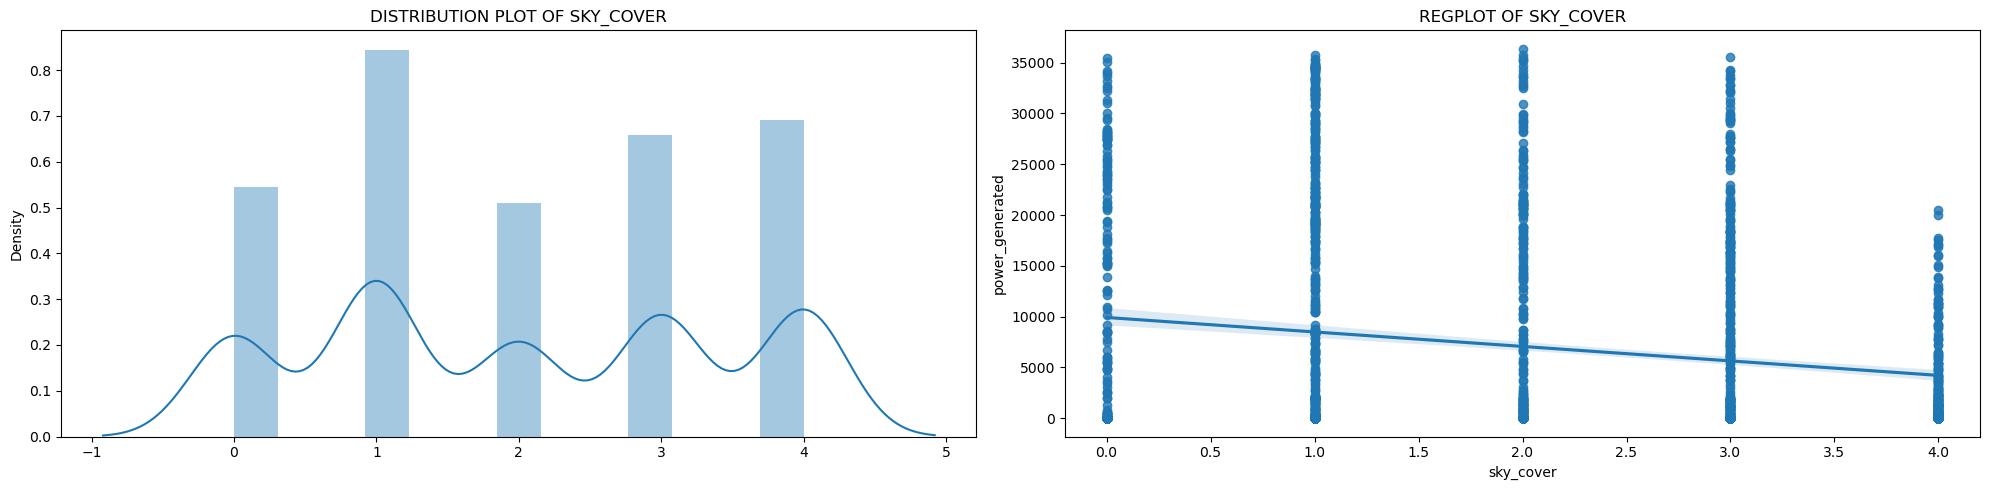

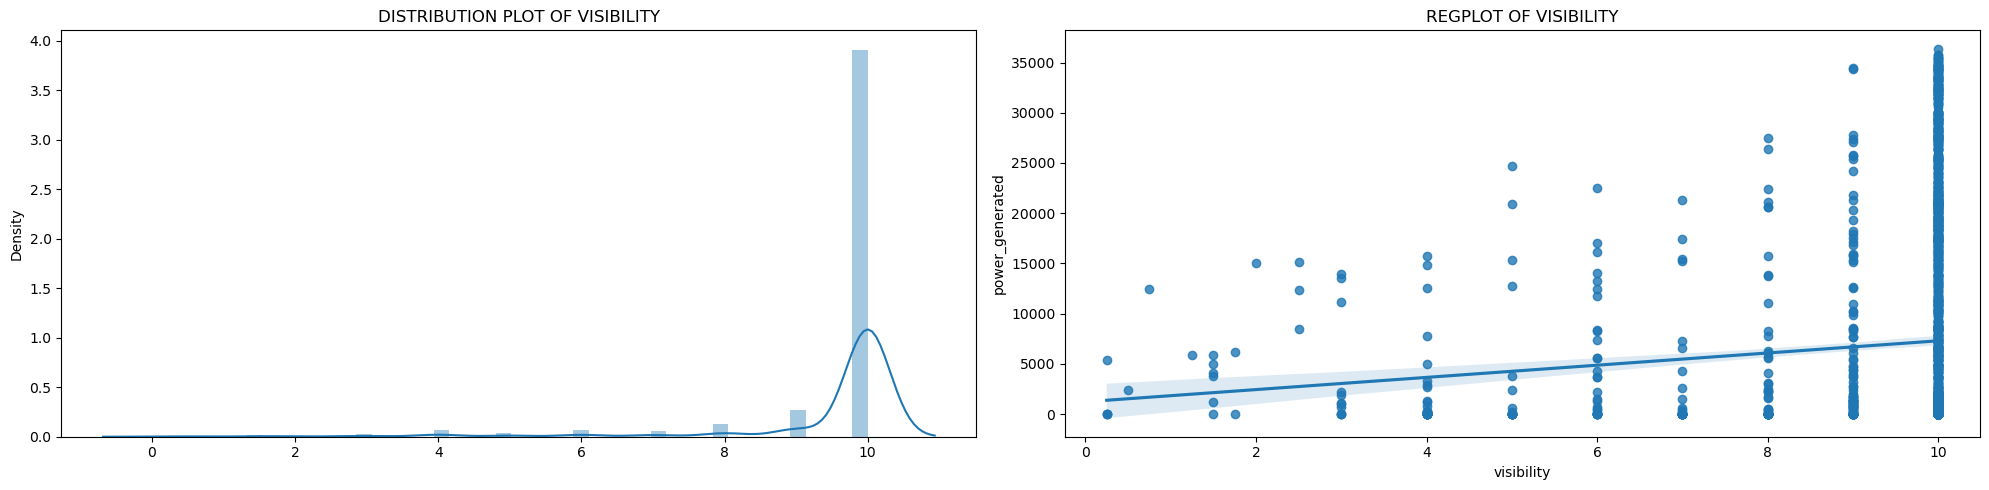

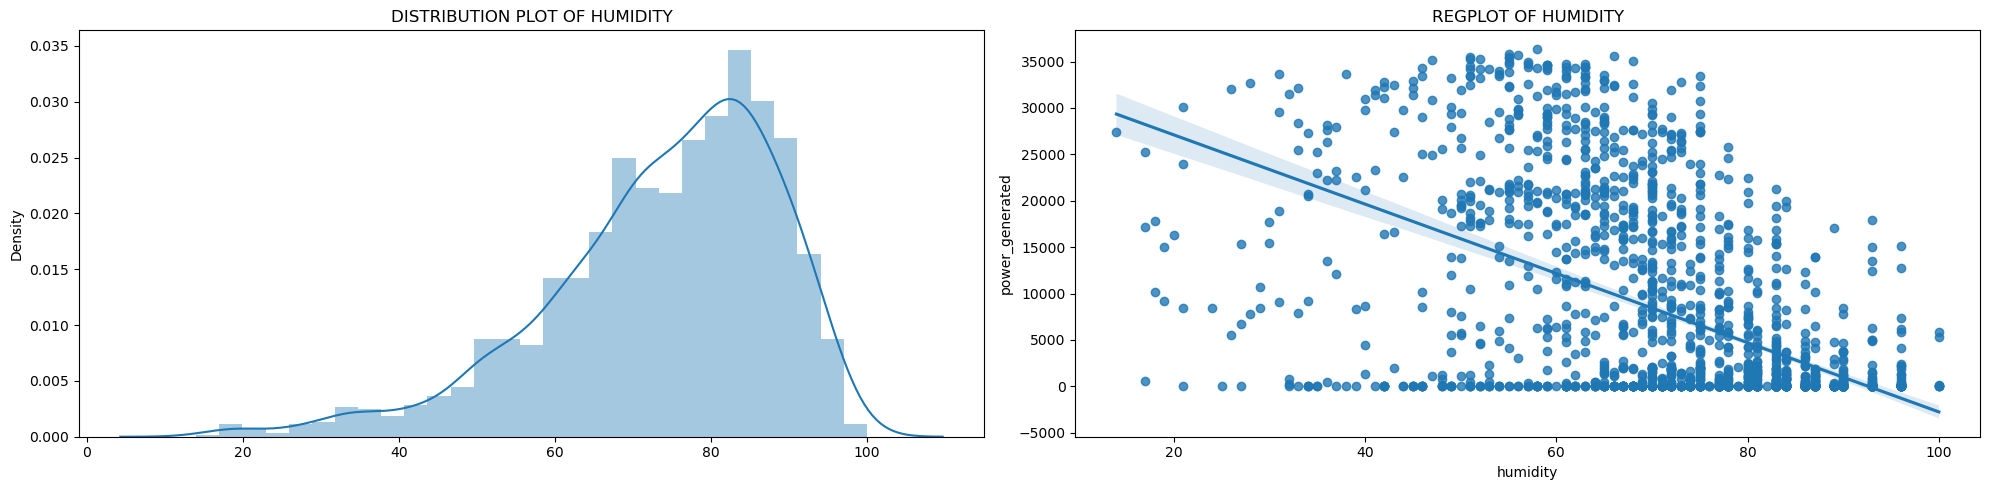

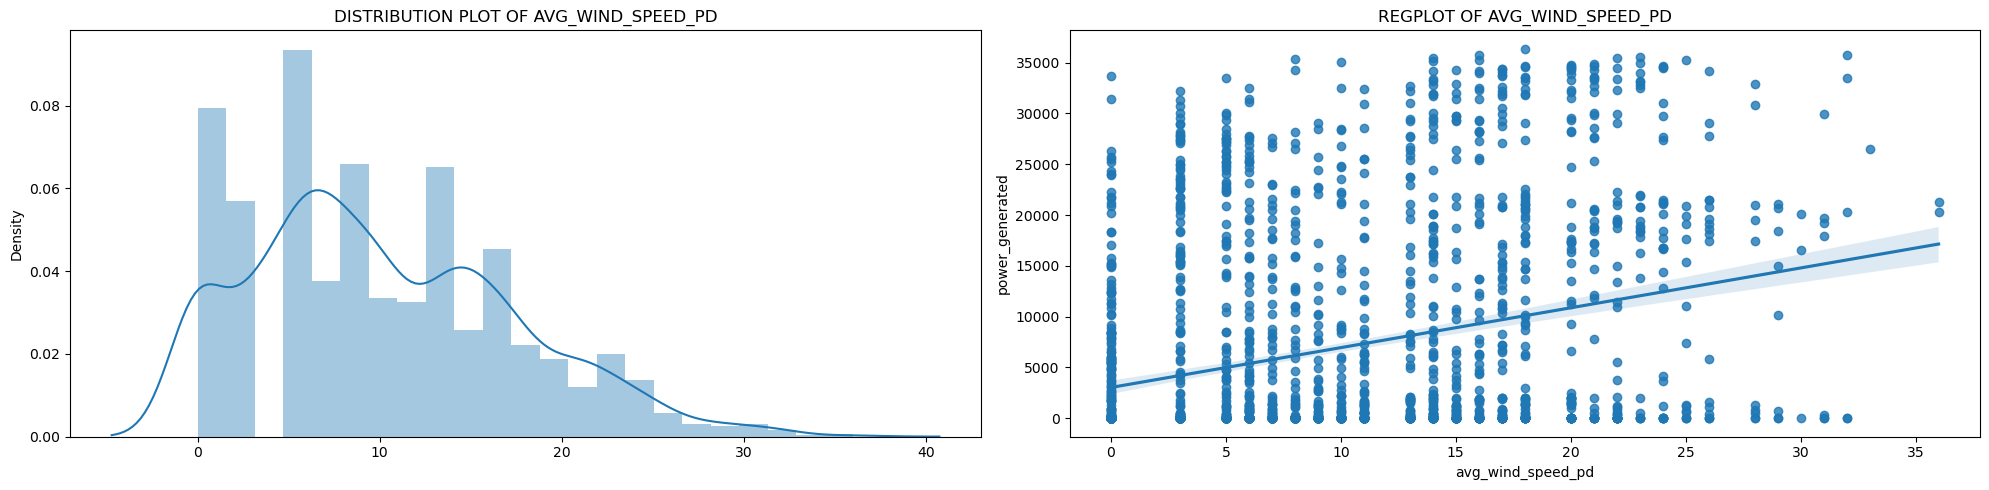

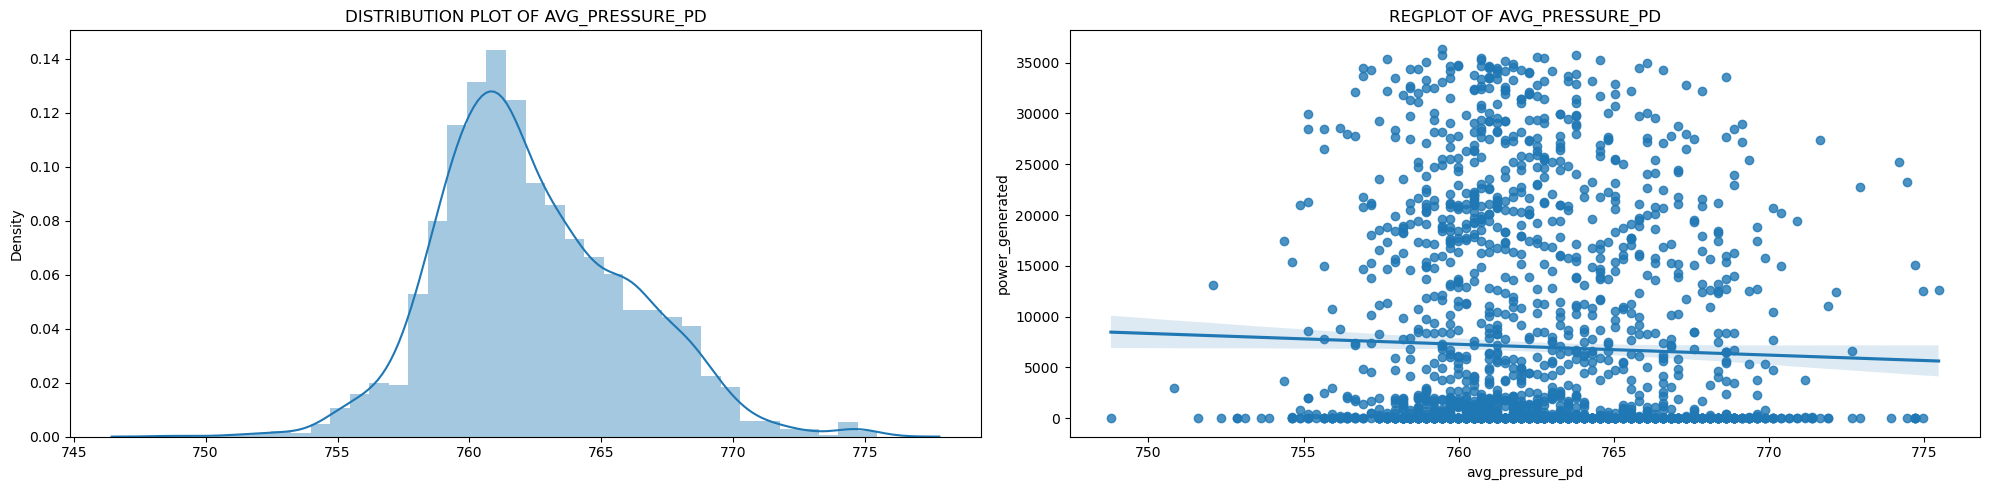

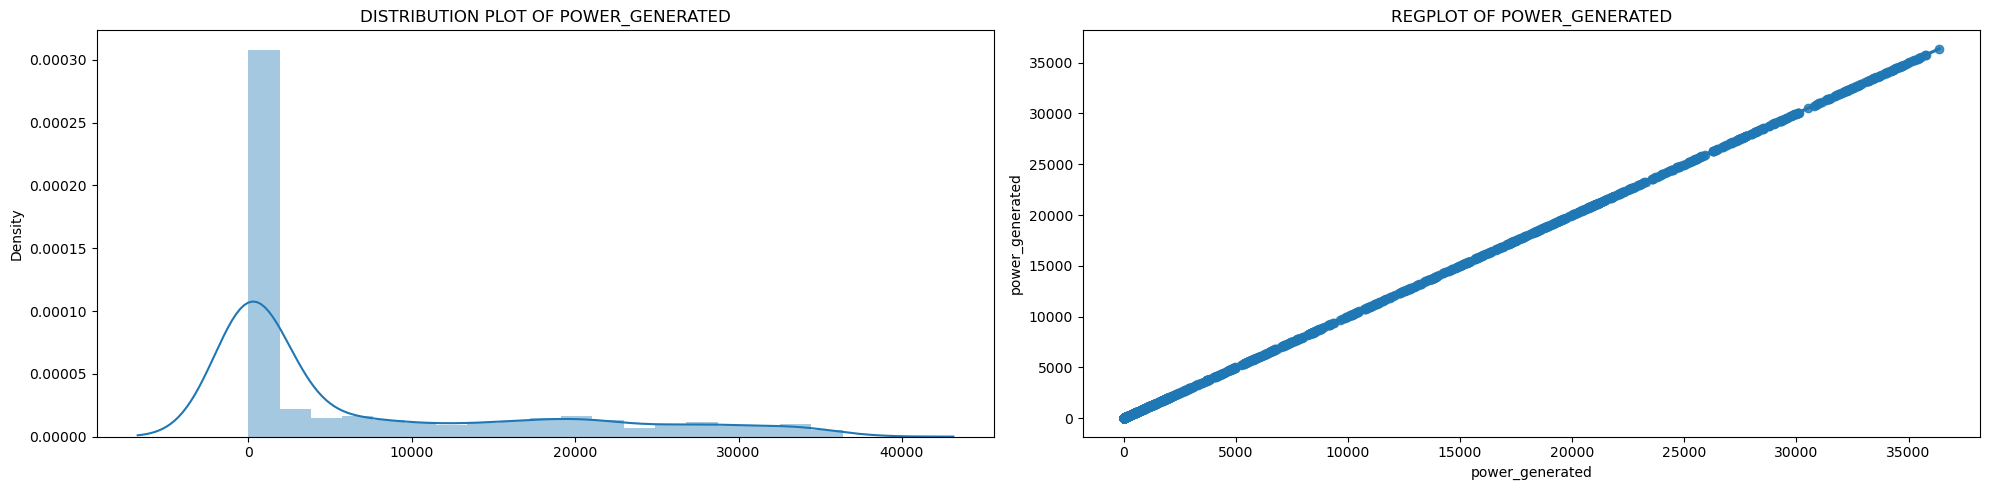

In [13]:
##PLOT OF DISTRIBUTION PLOT AND REGPLOT TO CHECK THE RELATIONSHIP BETWEEN THE TARGET AND FEATURES.

for num in df.columns:
    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    plt.title(f'distribution plot of {num}'.upper())
    sns.distplot(x =df[num]),
    
    
    
    plt.subplot(1,2,2)
    plt.title(f"REGPLOT OF {num}". upper())
    sns.regplot(x =df[num], y =df['power_generated'])
    plt.tight_layout()
    plt.show()

<Axes: >

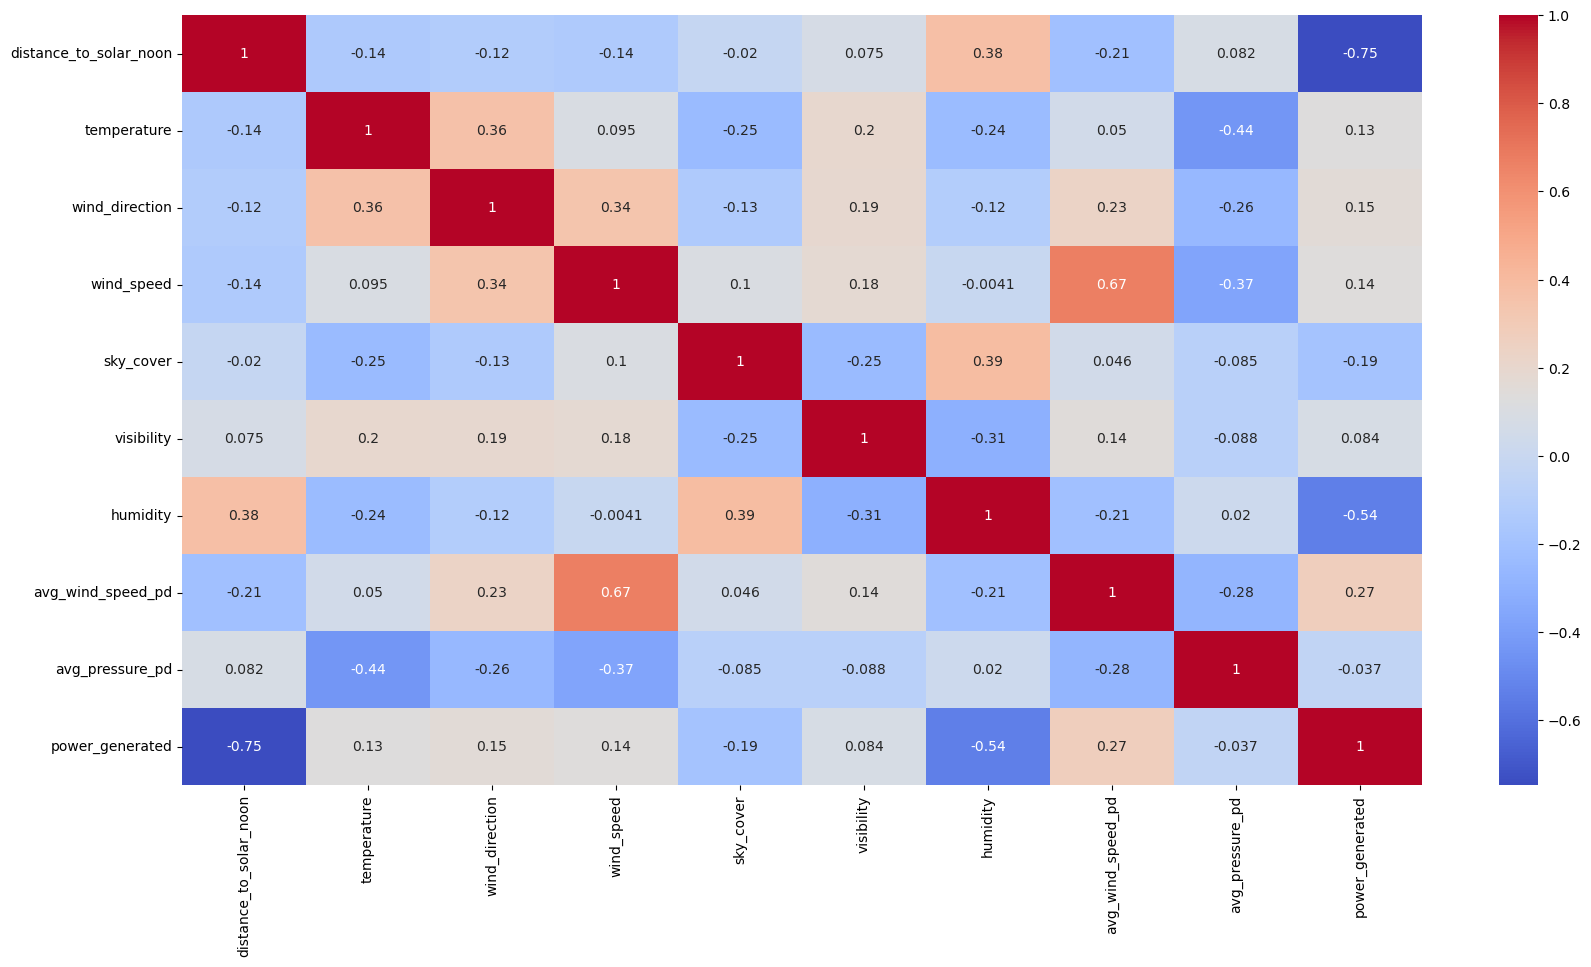

In [14]:
###corelation matrix
cor = df.corr()
#mask = np.triu(np.ones_like(cor))
plt.figure(figsize=(20,10))
sns.heatmap(cor, annot=True, cmap='coolwarm')

In [15]:
### WE CAN OBSERVE THAT SOME OF OUR COLUMNS CONTAINED OUTLIERS AND THE DISTRIBUTION IS NOT GAUSSION IN SOME CASES.
###FROM THE CORREALTION MATRIX WE CAN SEE THAT DISTANCE_TO_SOLAR_NOON AND HUMIDITY ARE HIGHLY CPRREALTED WOTH THE TARGET COLUMN(POWER_GENERATED)

# FEATURE ENGINEERING AND SCALING OF FEATURES


In [16]:

def eng (data):
        
    # Feature interactions
    data['distance'] = (data['distance_to_solar_noon'] *1000)
    data["sin_wind_direction"] = np.sin(data["wind_direction"] * (2 * np.pi / 360))
    data['temp_hum'] = data['humidity'] / data['temperature']
    data['sky_vis'] = data['sky_cover'] *data['visibility']
    data['humd_per_wind_speed'] = data['visibility'] / data['wind_speed']
    data['distance_wind_dire'] = data['distance'] * data['wind_direction']
    data =data.drop(columns= ['distance'])
    return data
df= eng(df)
test =eng(test)

In [17]:
###SCALING OF FEATURES IN TRAINING SET
def scale(data):
    
    scaler = MinMaxScaler()
    for col in data.drop(columns=['power_generated']).columns:
        data[col]=scaler.fit_transform(data[[col]])
    return data
df =scale(df)

####FEATURES SCALING IN TEST SET
def scale(data):
    
    scaler = MinMaxScaler()
    for col in data.columns:
        data[col]=scaler.fit_transform(data[[col]])
    return data

test=scale(test)


<Axes: title={'center': 'SQUARE ROOT OF POWER GENERATED'}, xlabel='power_generated'>

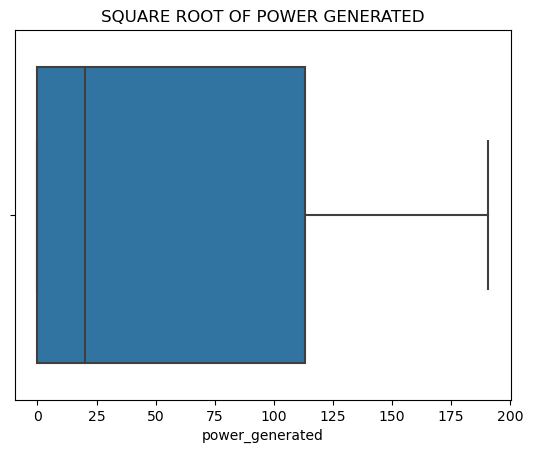

In [18]:
plt.title(f"SQUARE ROOT OF POWER GENERATED")
sns.boxplot(x=np.power(df['power_generated'], 1/2))

In [19]:
X = df.drop(columns=['power_generated'])
y = np.power(df['power_generated'], 1/2)
#X_train , X_test, Y_train , Y_test = train_test_split(X, y, test_size= .2 ,random_state= 3000)

In [20]:
##CATBOOST PARAMETERS USE TO BUILD THE MODEL
params ={'colsample_bylevel': 0.5659153725449974,
 'iterations': 685,
 'learning_rate': 0.09910678481011073,
 'l2_leaf_reg': 3.9840506062692187,
 'depth':  5,
 'random_strength': 0.2095107123503719,
 'min_data_in_leaf': 17,
 'max_bin': 222,
 'leaf_estimation_iterations': 3}

In [21]:
##KFOLD WITH 5 SPLIT

num_split=5
rand_state=3000
kf = KFold(n_splits= num_split, shuffle=True, random_state= rand_state)
test_preds = np.empty((num_split, len(test)))

## list of mean squared error 
mse_list = []

for i , (train_idx, test_idx) in enumerate(kf.split(X, y)):
    
    ###TRAIN TEST SPLIT
    x_train, x_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    ##POOLING FROM CATBOOST
    train_pool = Pool(x_train,y_train )
    test_pool = Pool(x_test, y_test )
    
    ##MODEL BUILDING
    model =CatBoostRegressor(**params)
    model.fit(train_pool, eval_set=test_pool, verbose=100)
    
    ##PREDICTION ON THE VALIDATION SET
    y_pred = model.predict(x_test)
    
    ####PREDICTION ON THE UNSEEN DATA SET (TEST SET)
    tp = model.predict(test)
    test_preds[i, :] = tp
    
    ##MSE SCORE ON EACH FOLD 
    score = mean_squared_error(y_test, y_pred)
    print(f'fold {i +1} MSE: {score}')
    print("_"*60)
    
    ##LET US APPEND ALL THE MSE SCORE IN THE mse_list DEFINED EARLIER
    mse_list.append(score)
    
    print("_"*60)
print(f"THE AVERAGE MEAN SQUARED ERROR ACROSS THE {num_split} FOLDS IS: {np.mean(mse_list)}")    
    

0:	learn: 58.7430123	test: 58.3599363	best: 58.3599363 (0)	total: 178ms	remaining: 2m 1s
100:	learn: 13.1791565	test: 16.5918529	best: 16.5716423 (96)	total: 715ms	remaining: 4.13s
200:	learn: 9.9124431	test: 16.5133994	best: 16.3904493 (148)	total: 1.15s	remaining: 2.76s
300:	learn: 7.9443554	test: 16.4797287	best: 16.3904493 (148)	total: 1.58s	remaining: 2.02s
400:	learn: 6.5957401	test: 16.4187585	best: 16.3783980 (353)	total: 2.02s	remaining: 1.43s
500:	learn: 5.6667246	test: 16.3744375	best: 16.3499410 (484)	total: 2.47s	remaining: 906ms
600:	learn: 4.8221084	test: 16.3495758	best: 16.3466067 (593)	total: 2.9s	remaining: 405ms
684:	learn: 4.2551132	test: 16.3409887	best: 16.3165544 (676)	total: 3.26s	remaining: 0us

bestTest = 16.31655439
bestIteration = 676

Shrink model to first 677 iterations.
fold 1 MSE: 266.2299486729958
____________________________________________________________
____________________________________________________________
0:	learn: 58.7639289	test: 58.38894

In [22]:
###WE NEED TO SQUARE THE PREDICTED VALUE IN ORDER TO OBTAIN THE CORRECT RESULT
y_pred = test_preds.mean(axis=0)
TP = np.power(y_pred, 2)


In [23]:
## STORING OF PREDICTED VALUES
df_sub = pd.read_csv('SampleSubmission.csv')
df_sub['power_generated'] = TP
df_sub[['power_generated']]

,power_generated
0,19160.074666
1,705.940854
2,17429.873888
3,1321.757150
4,18133.200008
...,...
872,0.001551
873,7177.704607
874,0.061663
875,46.237897


In [24]:
###SUBMISSION FILE
df_sub.to_csv('submissionABc.csv',index=False)